# Example: Evaporation and Condensation of Multiple Chemical Species

In this notebook, we will go over how the evaporation and condensation of the components that are active in gas and dust work:
First, we set up the simulation with an active component as described in the previous chapter:

In [1]:
from tripodpy import Simulation
import numpy as np
import dustpy.constants as c
import matplotlib.pyplot as plt

In [2]:
sim = Simulation()
sim.ini.grid.Nr = 500
sim.initialize()

we prepared a textfile with some example Species to get you started with an example disk, it contains most of the necesary parameters to have a disk with coposition which are:

- Species 
name of the element/molecule being tracked

- Abundance 
Abuncance relative to the total gas content

- nu_des
The attempt frequency if set to -1 we assume that the component is only present in the gas

- T_bind 
The binding energy (in Kelvin)

- mu 
Mean moleculat weight of the molecule

Further parameters that you need to set but are not part of the file as they are:

- rhos
bulk density of the componets when part of the dust

In [3]:
data = np.genfromtxt(
    'chem.txt',
    dtype=None,     # Automatically determine data types
    names=True,     # Use first non-skipped line as column names
    encoding='utf-8',  # Handle text encoding
    usecols=(0, 1, 2, 3, 4, 5),  # Specify columns to read
    comments='#'    # Skip lines starting with #
)

In [4]:
#print the text file
with open('chem.txt', 'r', encoding='utf-8') as f:
    print(f.read())

# Species Abundance nu_des T_bind mu p_stick  Ref
H2O       1.6e-4   4.0e13 5800    16  1.0      Fraser_2001
CO2       4.0e-5   1.0e13 2700    44  1.0      Sandford_1990
CO        8.0e-5   7.0e11 1180    28  1.0      Fayolle_2016
CH4       0.0e-0   -1     1250    16  1.0      Penteado_2017
C2H6      1.5e-5   6.0e16 2500    30  1.0      Behmard_2019
CH3OH     0.0e-0   -1     4930    32  1.0      Penteado_2017
N2        3.0e-5   8.0e11 1050    28  1.0      Fayolle_2016
NH3       7.0e-6   1.0e13 3800    17  1.0      Suhasaria_2015
He        9.5e-2   -1     100     4   1.0      Penteado_2017
Ar        2.5e-6   6.0e11 870     40  1.0      Smith_2016
Kr        1.8e-9   1.2e14 1380    83  1.0      Smith_2016
Xe        1.7e-10  4.6e14 1970    131 1.0      Smith_2016
H2S       1.4e-6   -1     2290    34  1.0      Penteado_2017
SO2       6.5e-6   -1     3010    64  1.0      Penteado_2017
FeS       6.5e-6   1.4e14 16040   87  1.0      Ferro_1989


the additional Species can then be added in the folowing way:

In [5]:
# Initialize residual gas surface density to total gas surface density
Sig_residual = sim.gas.Sigma.copy()
frac_h = 0.9118
sim.gas.mu = np.ones_like(sim.gas.mu)*(frac_h * c.m_p + (1 - frac_h) * 4 * c.m_p) / ( 0.5 * frac_h + (1 - frac_h))  # Initial mean molecular weight

mHe = (2 * sim.gas.mu/c.m_p - 4) / (4 - sim.gas.mu/c.m_p) # drift composition calculation -> molecular vs atomic (H)  He mass fraction 
for element in data:
        # component that only has gas phase
    mass_frac = element['Abundance'] * element['mu'] / (frac_h + 4*(1-frac_h)) #mass fraction relative to the approximate atomic mean mass in the disc


    if element["nu_des"] <= 0:
        sim.addcomponent(
        element['Species'],
        sim.gas.Sigma*mass_frac,
        element['mu']*c.m_p,
        dust_active=False,
        gas_active=True)
        Sig_residual -= sim.gas.Sigma*mass_frac

        # component that has both gas and dust phases
    else:
        # truncate the component where dust surface density floor is reached
        factor = np.where(sim.dust.Sigma[:,0] > sim.dust.SigmaFloor[:,0], 1.0, 0.0)
        sim.addcomponent(
            element['Species'],
            sim.gas.Sigma*mass_frac*factor,
            element['mu']*c.m_p,
            dust_active=True,
            gas_active=True,
            rhos=1.,
            dust_value = sim.dust.SigmaFloor.copy()
        )
        sim.components.__dict__[element[0]].gas.pars.nu = element['nu_des']
        sim.components.__dict__[element[0]].gas.pars.Tsub = element['T_bind']

    # Subtract assigned gas from residual gas surface density
    Sig_residual -= sim.gas.Sigma*mass_frac

# Add the background silicate dust component
sim.addcomponent("silicates",
    sim.gas.SigmaFloor,
    1.,
    dust_active=True,
    gas_active=False,
    rhos=3.5,
    dust_value = sim.dust.Sigma.copy())

# Note that we have to subtract the assigned gas from the Default component and reassign it H2 like properties
sim.components.Default.gas.Sigma = Sig_residual*2 # Assign remaining gas to Default component TODO: why factor 2?
sim.components.Default.gas.pars.mu = 2*c.m_p # Ensure Default behaves Like is H2
sim.update()

In [6]:
# you can check the components added in the simulation by running
sim.components

Group (components)
------------------
    Ar           : Group (Ar (dust_tracer=False, gas_active=True, gas_tracer=False))
    C2H6         : Group (C2H6 (dust_tracer=False, gas_active=True, gas_tracer=False))
    CH3OH        : Group (CH3OH (dust_tracer=False, gas_active=True, gas_tracer=False))
    CH4          : Group (CH4 (dust_tracer=False, gas_active=True, gas_tracer=False))
    CO           : Group (CO (dust_tracer=False, gas_active=True, gas_tracer=False))
    CO2          : Group (CO2 (dust_tracer=False, gas_active=True, gas_tracer=False))
    Default      : Group (Default gas componentDefault (dust_tracer=False, gas_active=True, gas_tracer=False))
    FeS          : Group (FeS (dust_tracer=False, gas_active=True, gas_tracer=False))
    H2O          : Group (H2O (dust_tracer=False, gas_active=True, gas_tracer=False))
    H2S          : Group (H2S (dust_tracer=False, gas_active=True, gas_tracer=False))
    He           : Group (He (dust_tracer=False, gas_active=True, gas_tracer

Now lets plot the inital gas and dust surface densities of each component:

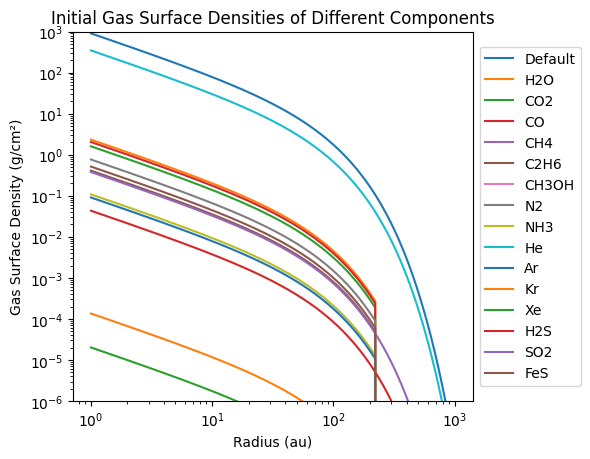

In [7]:
plt.figure()
plt.title('Initial Gas Surface Densities of Different Components')
for name, comp in sim.components.__dict__.items():
    if(name.startswith("_")):
            continue
    if comp.gas._active:
        plt.loglog(sim.grid.r/c.au, comp.gas.Sigma, label=name)

plt.xlabel('Radius (au)')
plt.ylabel('Gas Surface Density (g/cm²)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(right=0.75)
plt.ylim(1e-6, 1e3)
plt.show()

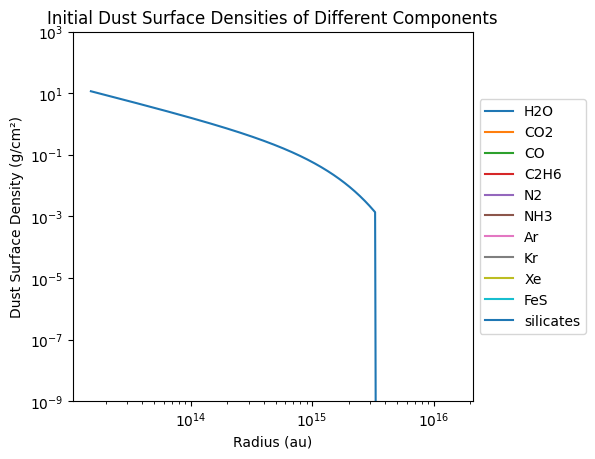

In [8]:
plt.figure()
plt.title('Initial Dust Surface Densities of Different Components')
for name, comp in sim.components.__dict__.items():
    if(name.startswith("_")):
            continue
    if comp.dust._active:
        plt.loglog(sim.grid.r, comp.dust.Sigma.sum(-1), label=name)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(right=0.75)
plt.ylim(1e-9, 1e3)
plt.xlabel('Radius (au)')
plt.ylabel('Dust Surface Density (g/cm²)')
plt.show()

as we can see we initalized the gas and dust surface densities according to the chem.txt file with all the components being fully in the gas phase at t=0.

Now lets run the simulation and check how the components evolve by condensing onto the grains

In [9]:
sim.writer.datadir = "6_data"
sim.run()


tripodpy v1.0.0

Creating data directory 6_data.
Writing file 6_data/data0000.hdf5
Writing dump file 6_data/frame.dmp
Writing file 6_data/data0001.hdf5
Writing dump file 6_data/frame.dmp
Writing file 6_data/data0002.hdf5
Writing dump file 6_data/frame.dmp
Writing file 6_data/data0003.hdf5
Writing dump file 6_data/frame.dmp
Writing file 6_data/data0004.hdf5
Writing dump file 6_data/frame.dmp
Writing file 6_data/data0005.hdf5
Writing dump file 6_data/frame.dmp
Writing file 6_data/data0006.hdf5
Writing dump file 6_data/frame.dmp
Writing file 6_data/data0007.hdf5
Writing dump file 6_data/frame.dmp
Writing file 6_data/data0008.hdf5
Writing dump file 6_data/frame.dmp
Writing file 6_data/data0009.hdf5
Writing dump file 6_data/frame.dmp
Writing file 6_data/data0010.hdf5
Writing dump file 6_data/frame.dmp
Writing file 6_data/data0011.hdf5
Writing dump file 6_data/frame.dmp
Writing file 6_data/data0012.hdf5
Writing dump file 6_data/frame.dmp
Writing file 6_data/data0013.hdf5
Writing dump file 6

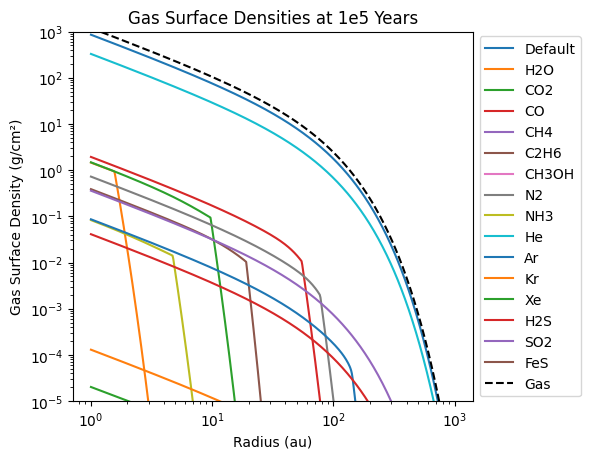

In [10]:
plt.figure()
plt.title('Gas Surface Densities at 1e5 Years')
for name, comp in sim.components.__dict__.items():
    if(name.startswith("_")):
            continue
    if comp.gas._active:
        plt.loglog(sim.grid.r/c.au, comp.gas.Sigma, label=name)

plt.loglog(sim.grid.r/c.au, sim.gas.Sigma, "k--", label="Gas")
plt.xlabel('Radius (au)')
plt.ylabel('Gas Surface Density (g/cm²)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(right=0.75)
plt.ylim(1e-5, 1e3)
plt.show()

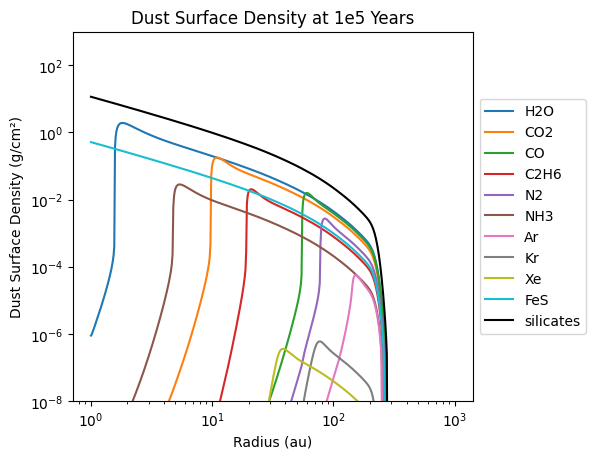

In [11]:
plt.figure()
plt.title('Dust Surface Density at 1e5 Years')
for name, comp in sim.components.__dict__.items():
    if(name.startswith("_") or name=="silicates"):
            continue
    if comp.dust._active:
        plt.loglog(sim.grid.r/c.au, comp.dust.Sigma.sum(-1), label=name)
comp= sim.components.__dict__["silicates"]
plt.loglog(sim.grid.r/c.au, comp.dust.Sigma.sum(-1), "k",label=name)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(right=0.75)
plt.ylim(1e-8, 1e3)
plt.xlabel('Radius (au)')
plt.ylabel('Dust Surface Density (g/cm²)')
plt.show()

as we can see the components freeze out onto the grains where the temperature is low enough as expected, we can also look what efect this has on the bulk density of the dust and the mean molecular weight of the gas disk:

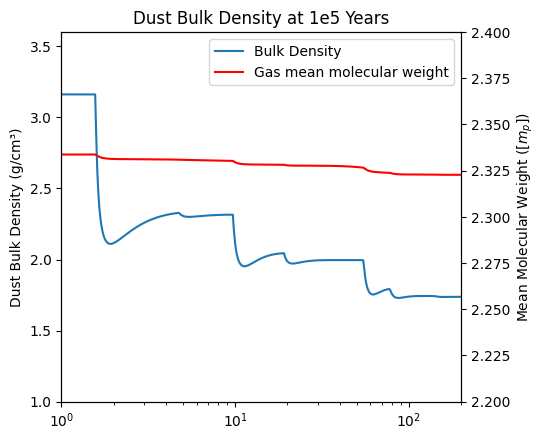

In [12]:
plt.figure()
plt.title('Dust Bulk Density at 1e5 Years')
plt.plot(sim.grid.r/c.au, sim.dust.rhos[:,0], label="Bulk Density")
plt.plot([],[], "r",label="Gas mean molecular weight")
ax = plt.gca()
plt.legend()
ax2 = ax.twinx()
ax2.plot(sim.grid.r/c.au, sim.gas.mu/c.m_p, "r",label="Total Dust")
plt.xscale('log')
plt.subplots_adjust(right=0.75)
plt.xlabel('Radius (au)')
ax.set_ylabel('Dust Bulk Density (g/cm³)')
ax2.set_ylabel('Mean Molecular Weight ([$m_p$])')
ax.set_ylim(1,3.6)
ax2.set_ylim(2.2,2.4)
plt.xlim(1,200)
plt.show()